In [1]:
import pandas as pd
import numpy as np
import fastai
from sklearn.model_selection import StratifiedKFold
import torchvision.models as torch_models
import dill
from fastai.vision.all import *


In [2]:
fastai.__version__

'2.3.0'

# About
This notebook trains a simple model for the [Hotel-ID to Combat Human Trafficking 2021 - FGVC8](https://www.kaggle.com/c/hotel-id-2021-fgvc8/overview) competition.
The notebook uses the downsized version of the competiton train images. The max height or width is 512 pix. The score can be improved by running more epochs.

In [3]:
kaggle_path = '../input/hotel-id-2021-fgvc8/'
train_img_path = '../input/fgvc8hoteltrain512/'

Set the DEBUG flag = `True` to construct a validation set and to restrict the number of train data. Set the flag = `False` to train on the entire set without validation set. 

In [4]:
DEBUG = False

# Load train info and define validation set
Load train image descriptions and add path information of downsized images.

In [5]:
train = pd.read_csv(kaggle_path+'train.csv').sample(frac=1, random_state = 2021).reset_index(drop = True)

# add image path
train['image'] = train_img_path + train.chain.astype('str') + '/' + train.image


If in DEBUG mode limit data and construct validation set.

In [6]:
if DEBUG:
    ## Map chains to 6 buckets.
    train['h_c'] = train['hotel_id'].astype('str')+' c'+train['chain'].astype('str')
    train['chain_bucket']=train['chain'].map({0:1,
                                               6:2,
                                               5:3,
                                               90:4,
                                               3:4,
                                               89:4,
                                               87:5,
                                               4:5,
                                               2:5,
                                               88:5,
                                               9:6,
                                               82:6,
                                               78:6}).fillna(0)
    
    # Do a stratified KFold to construct a proper validation set.
    skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)

    train.kfold = -1

    for f, (t,v) in enumerate(skf.split(X = train, y = train.hotel_id.values)):
        train.loc[v, 'kfold'] = f

    train.groupby('kfold')['hotel_id'].count()

In [7]:
train['is_demo_valid'] = False

if DEBUG:
    # limit data to one bucket
    train=train[train.chain_bucket==6]
    # set fold 0 as validation set
    train.loc[train['kfold'] == 0, 'is_demo_valid'] = True

train[(train.is_demo_valid)]

,image,chain,hotel_id,timestamp,is_demo_valid


# Dataloader and augmentation
Setting pad_mode to `reflection` gave a significant boost.

In [8]:
dls = ImageDataLoaders.from_df(df = train[['image', 'hotel_id', 'is_demo_valid']], path = '.',folder = '.', valid_col = 'is_demo_valid',
                                item_tfms=Resize(448, method='pad', pad_mode='reflection')
                               ,batch_tfms=aug_transforms(size=224)
                               ,bs=32)

Check some augmented sample images.

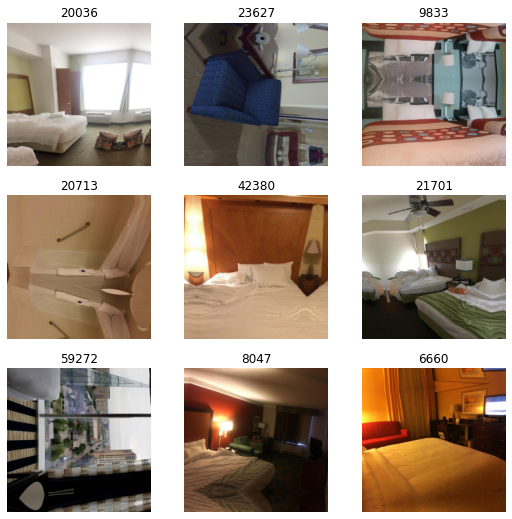

In [9]:
dls.show_batch() 

# Training
Densenet161 worked best in my experiment but training is slow. Resnet101 was a good faster alternative but results were slightly worse. CrossEntropy-Loss (CE) worked better for me than label smoothing and a bit better than FocalLoss (FL).

QHAdam gave a significant boost.

In [10]:
learn = cnn_learner(dls, densenet161, metrics=[accuracy, top_k_accuracy], opt_func=QHAdam).to_fp16()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [11]:
%time

learn.fine_tune(12, 0.005, freeze_epochs=3)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,8.205667,None,None,None,26:36
1,6.461273,None,None,None,26:01
2,5.427440,None,None,None,25:56


/opt/conda/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.152317,None,None,None,33:35
1,3.879772,None,None,None,33:03
2,3.881218,None,None,None,33:14
3,3.417412,None,None,None,33:09
4,2.873135,None,None,None,33:06
5,2.334295,None,None,None,33:22
6,1.869616,None,None,None,33:32
7,1.468919,None,None,None,33:42
8,1.019183,None,None,None,33:19
9,0.632627,None,None,None,33:23


In [12]:
learn.export(f'export_dn161_kaggle_notebook.pkl', pickle_module=dill)